# DLToolboxImg: Part 2
A set of helper functions that one repeatedly need to construct a dataset from raw images, visualise the performance of a neural network while it is getting trained, evaluate the performance of a model after training is completed. 

As a running example, I will apply the functinos on the LIDC dataset.

# Table of Contents
- [Generate Dataset](#generatedata)
    - [Generate Negative Examples](#neg)
    - [Generate Positive Examples](#pos)
    - [Combine both into a distribution of n:m (pos:neg)](#dist)
- [Data Augmentation](#augment)


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib nbagg

In [2]:
from imports import *

<a id="generatedata"></a>
## Generate Dataset 


First, lets load the indices for train, valid, and test sets

In [3]:
root_dir="drive/"
interm_dir=root_dir+"interm5/"
filename=interm_dir+"scan_id_split"
with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
    scan_id_train,scan_id_valid,scan_id_test=pickle.load(f)

In [4]:
scan_id_train,scan_id_valid,scan_id_test

([15, 16, 17, 20, 22, 23], [19], [18, 21, 14])

<a id="neg"></a>
### Generate Negative Examples

In [5]:
!mkdir /home/mas/x110/data/
!mkdir /home/mas/x110/data/pos
!mkdir /home/mas/x110/data/neg

mkdir: cannot create directory ‘/home/mas/x110/data/’: File exists
mkdir: cannot create directory ‘/home/mas/x110/data/pos’: File exists
mkdir: cannot create directory ‘/home/mas/x110/data/neg’: File exists


In [6]:
interm_dir2='/home/mas/x110/data/pos'
interm_dir3='/home/mas/x110/data/neg'
interm_dir4='/home/mas/x110/data'


I will be taking small cubes from the ctscan volume. The size of this small cube is 52x52x52. I can serially decompose the say 512x512x300 ctscan volume into 52x52x52 cubes. But the problem with this approach is that I will have many "unintresting" cubes. like cubes that are all black. As an alternative, I will first create a lung mask. pick random points that resides inside the lung mask, and extract the 52x52x52 cube where the random point is the center of that cube. As a final check, I will make make sure that there does not exist a nodule in that cube, because remember we ar now generating negative examples. A summary of what I just described is:

1. get a scan
2. Apply the lung mask 
3. Find the range of zs where the lung occupies >2% of the total area. 
4. Select a random zc location.
5. On that z slice, apply the lung mask.
6. Select a random xc,yc point that resides inside the lung mask.
7. extract a cube where xc,yc,zc is its center and its side is N=52.
8. sum the mask of the newly generated cube to ensure that it does not include a nodule. 
9. The naming convention would be neg_scan_id_cx_xy_cz

In [7]:
random.seed(313)
for scan_id in scan_id_train:#[xx+1:]:
    scan_1 = ctscan(scan_id) 
    S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

    T = B.shape[1]**2
    Areas=[np.sum(b)/T for b in B]
    ind2=[i for i,a in enumerate(Areas) if a>.02]
    z1,z2=ind2[0],ind2[-1]

    for k in range(10):
        zz=np.random.randint(z1,z2)

        Bf=B[zz].flatten()
        #In that slice, find the elements that are true
        Cs=[i for i,e in enumerate(Bf) if e]
        #randomly select an element from Cs
        i = random.choice(Cs)
        #from i get the original row and column of that element in B
        a=B.shape[1];a
        r = i//a
        c=i-a*r

        #Thus, we have succssfully selected a random point that resides inside the lung area
        #we would like to extract a 52x52x52 patch from the ctscan volume.
        #The patch is centered at the conditioned random point we have generated
        m = 52
        cz,cy,cx =[zz,r,c]
        #grap the volume
        image=scan_1.image_normalized #zxy
        cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
        cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)
        if np.sum(cube_label)==0:
            #save file
            filename=interm_dir3+'/data_N_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
            with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([cube_img,cube_label.astype(np.bool)], f)
        else:
            k=k-1

#x=[i for i,j in enumerate(scan_id_train) if j==scan_id]
#xx=x[0]

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


#### Read Negative Examples
it is handy to create a csv file that contains a list of the file names and its class and some other features

In [8]:
if True:
    temp=!ls {interm_dir3} -irlat #>> myfiles2.csv
    #keep string that satisfy a condition
    temp1=[t for t in temp if "data" in t]
    temp1[0:5]

    temp2=[t.split(" ")[-1] for t in temp1]

    df=pd.DataFrame([t.split(".")[0].split("_")[-4:] for t in temp2],columns=['scan_id','x','y','z'])

    df['label']=0
    df['filename']=temp2
    df.to_csv(interm_dir4+"/df_neg_scanid_centroid.csv")
else:
    df=pd.read_csv(interm_dir4+"/df_neg_scanid_centroid.csv",index_col=0)
print(df.shape)
df.head(20)

(56, 6)


,scan_id,x,y,z,label,filename
0,15,172,216,254,0,data_N_15_172_216_254.pkl
1,15,139,240,154,0,data_N_15_139_240_154.pkl
2,15,171,272,229,0,data_N_15_171_272_229.pkl
3,15,198,225,76,0,data_N_15_198_225_76.pkl
4,15,147,238,88,0,data_N_15_147_238_88.pkl
5,15,158,285,97,0,data_N_15_158_285_97.pkl
6,15,152,186,238,0,data_N_15_152_186_238.pkl
7,15,332,205,105,0,data_N_15_332_205_105.pkl
8,15,152,215,186,0,data_N_15_152_215_186.pkl
9,15,172,219,147,0,data_N_15_172_219_147.pkl


<a id="pos"></a>
### Generate Positive Examples

Our Strategy is to:
- pick a nodule at random (repition not allowed)
- extract the 52x52x52 cube
- The naming convention would be pos_scan_id_cx_xy_cz

In [9]:
m = 52
for scan_id in scan_id_train:
    #grap the volume
    scan_1 = ctscan(scan_id)
    image=scan_1.image_normalized #zxy
    for c2 in scan_1.centroids2:
        cx,cy,cz =c2
        cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
        cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)
        filename=interm_dir2+'/data_P_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
        with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
            pickle.dump([cube_img,cube_label.astype(np.bool)], f)

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


In [69]:
if True:
    temp=!ls {interm_dir2} -irlat #>> myfiles2.csv
    #keep string that satisfy a condition
    temp1=[t for t in temp if "data" in t]
    temp1[0:5]

    temp2=[t.split(" ")[-1] for t in temp1]

    df=pd.DataFrame([t.split(".")[0].split("_")[-4:] for t in temp2],columns=['scan_id','x','y','z'])
    df['label']=1
    df['filename']=temp2
    #let us compute some analytics
    Area=[]
    for file in df.filename:
        filename=interm_dir2+'/'+file
        with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
            X,Y = pickle.load(f)
        Area.append(np.sum(Y)/52./52./52.*100)
    df["Area_percentage"] = Area
    
    df.to_csv(interm_dir4+"/df_pos_scanid_centroid.csv")
else:
    df=pd.read_csv(interm_dir4+"/df_pos_scanid_centroid.csv",index_col=0)
print(df.shape)
df.head(20)

(57, 7)


,scan_id,x,y,z,label,filename,Area_percentage
0,15,115,264,93,1,data_P_15_115_264_93.pkl,0.370534
1,15,116,264,95,1,data_P_15_116_264_95.pkl,0.370534
2,15,116,264,93,1,data_P_15_116_264_93.pkl,0.370534
3,15,115,264,95,1,data_P_15_115_264_95.pkl,0.370534
4,16,270,249,217,1,data_P_16_270_249_217.pkl,0.159308
5,16,206,269,200,1,data_P_16_206_269_200.pkl,0.345642
6,16,207,269,200,1,data_P_16_207_269_200.pkl,0.345642
7,16,83,263,192,1,data_P_16_83_263_192.pkl,0.119481
8,16,207,270,200,1,data_P_16_207_270_200.pkl,0.345642
9,17,118,212,135,1,data_P_17_118_212_135.pkl,0.104546


Let us double check

In [28]:
filename=interm_dir2+'/'+df.filename[0]
print(filename)
with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
    X,Y = pickle.load(f)

/home/mas/x110/data/pos/data_P_23_267_139_192.pkl


<IPython.core.display.Javascript object>


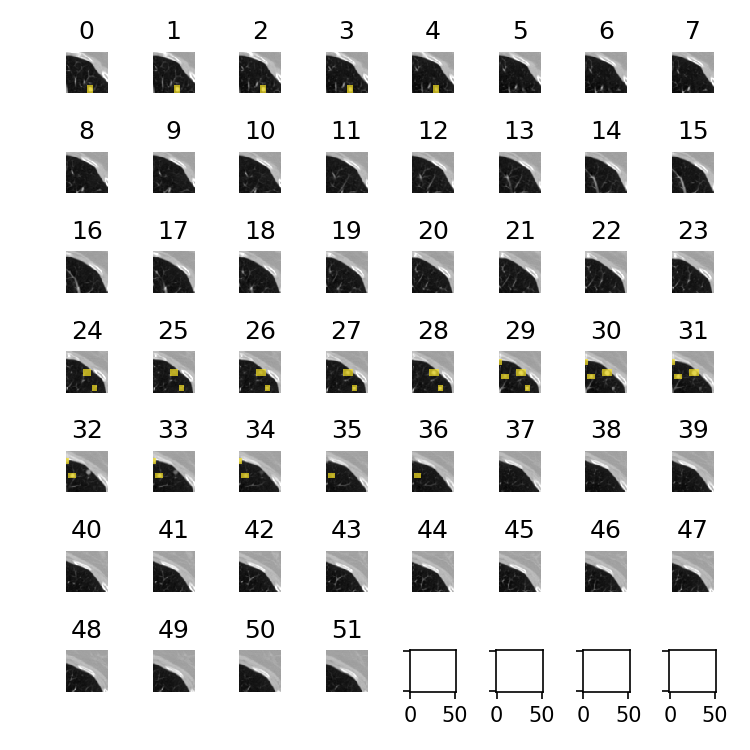

In [29]:
zs=52

X2 = X.copy()
Z2=Y.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=7
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(5,5))

ind=np.arange(0,52)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title(str(ii))
      
plt.tight_layout()

<a id="dist"></a>
### Combine both into a distribution of n:m (pos:neg)


In [9]:
dfp=pd.read_csv(interm_dir4+"/df_pos_scanid_centroid.csv",index_col=0)
del dfp["Area_percentage"]
dfp.head()

,scan_id,x,y,z,label,filename
0,15,115,264,93,1,data_P_15_115_264_93.pkl
1,15,116,264,95,1,data_P_15_116_264_95.pkl
2,15,116,264,93,1,data_P_15_116_264_93.pkl
3,15,115,264,95,1,data_P_15_115_264_95.pkl
4,16,270,249,217,1,data_P_16_270_249_217.pkl


In [10]:
dfn=pd.read_csv(interm_dir4+"/df_neg_scanid_centroid.csv",index_col=0)
dfn.head()

,scan_id,x,y,z,label,filename
0,15,172,216,254,0,data_N_15_172_216_254.pkl
1,15,139,240,154,0,data_N_15_139_240_154.pkl
2,15,171,272,229,0,data_N_15_171_272_229.pkl
3,15,198,225,76,0,data_N_15_198_225_76.pkl
4,15,147,238,88,0,data_N_15_147_238_88.pkl


In [11]:
dfp.shape[0],dfn.shape[0]

(57, 56)

In [12]:
df2= dfn.sample(frac=.08,random_state=313).reset_index(drop=True)
print(dfn.shape)
print(df2.shape)
df2.head()

(56, 6)
(4, 6)


,scan_id,x,y,z,label,filename
0,17,124,172,262,0,data_N_17_124_172_262.pkl
1,22,268,248,201,0,data_N_22_268_248_201.pkl
2,20,174,121,55,0,data_N_20_174_121_55.pkl
3,22,293,168,114,0,data_N_22_293_168_114.pkl


In [13]:
df=dfp.append(df2)

In [14]:
df= df.sample(frac=1,random_state=313).reset_index(drop=True)
print(df.shape)
df.head()

(61, 6)


,scan_id,x,y,z,label,filename
0,23,267,139,192,1,data_P_23_267_139_192.pkl
1,17,124,172,262,0,data_N_17_124_172_262.pkl
2,23,241,125,197,1,data_P_23_241_125_197.pkl
3,23,241,126,195,1,data_P_23_241_126_195.pkl
4,22,115,235,257,1,data_P_22_115_235_257.pkl


<a id="augment"></a>
### Data Augmentation

When I generated positive examples, I extracted the mini cube around the nodule. Hence, the nodule will always be at the center. Now, we need to change this by introducing some offset in all directions x,y,z.

The strategy is to get a random portion of this mini cube with the condition that the center should belong to the new "mini mini cube". The center of the original cube must contain a nodule (by design). Hence, this way we gurantee than the new cube will contain a nodule. 

By visually looking at the different scenarios of extracting a 32x32x32 cube from a 52x52x52 cube, I can say that all will contain the center.

In [53]:
random.seed(313)
def random_crop(img,label):
    #compute the upper left corner of the new cube
    x = random.randint(0, 20) #Assume input is 52x52x52
    y = random.randint(0, 20) #Assume input is 52x52x52
    z = random.randint(0, 20) #Assume input is 52x52x52
    img2 = img[x:x+32,y:y+32,z:z+32]
    label2 = label[x:x+32,y:y+32,z:z+32]

    return img2,label2

In [54]:
filename=interm_dir2+'/'+df.filename[0]
print(filename)
with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
    X,Y = pickle.load(f)

/home/mas/x110/data/pos/data_P_23_267_139_192.pkl


<IPython.core.display.Javascript object>


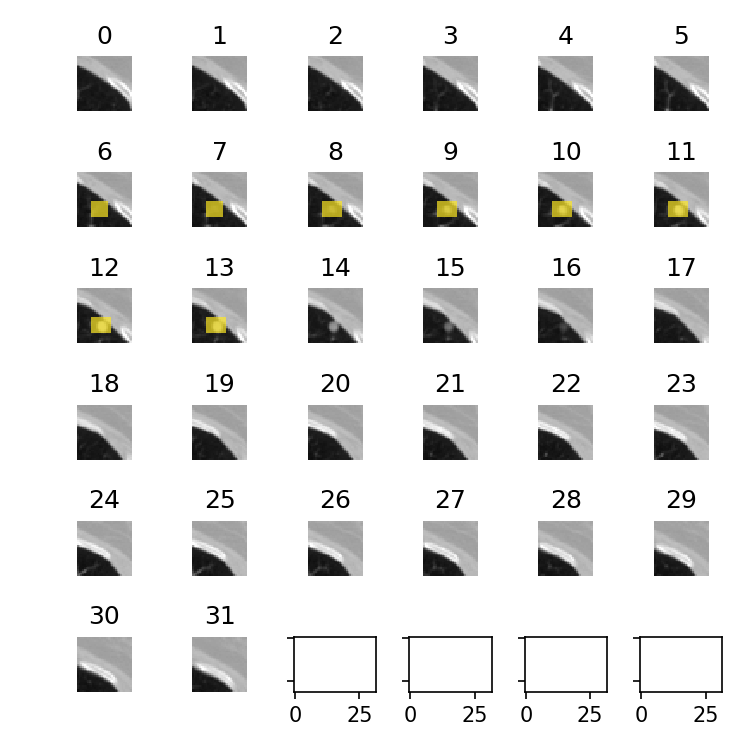

In [55]:
zs=32

X2,Z2 = random_crop(X,Y)
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=6
num_cols=6

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(5,5))

ind=np.arange(0,32)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title(str(ii))
      
plt.tight_layout()

Now we need to repeat this on all the data positive or negative to get the 

### Convert into rec file

In [56]:
import mxnet as mx #pip install mxnet-cu80
#write to .rec file
if True:#under development    
    fname=interm_dir4+'Train6Oct2018augment.rec'
    record = mx.recordio.MXRecordIO(fname, 'w')

    counter=0
    sum_img=np.zeros((32,32,32))


    for index, row in df.iterrows():
        if row['label']==1:
            path=interm_dir2
        else:
            path=interm_dir3

        filename=path+'/'+row.filename

        with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
            x,t=pickle.load(f)
            x,t = random_crop(x,t)



        sum_img+=x

        t=1*t.flatten()#(255*t.flatten()).astype(np.uint8)
        x=x.flatten()#(255*x.flatten()).astype(np.uint8)
        header = mx.recordio.IRHeader(flag=0, label=x, id=int(counter), id2=0)
        s = mx.recordio.pack_img(header, t, quality=100,img_fmt='.png')
        record.write(s)
        counter +=1
    record.close()

In [57]:
df

,scan_id,x,y,z,label,filename
0,23,267,139,192,1,data_P_23_267_139_192.pkl
1,17,124,172,262,0,data_N_17_124_172_262.pkl
2,23,241,125,197,1,data_P_23_241_125_197.pkl
3,23,241,126,195,1,data_P_23_241_126_195.pkl
4,22,115,235,257,1,data_P_22_115_235_257.pkl
5,22,81,245,70,1,data_P_22_81_245_70.pkl
6,23,286,219,157,1,data_P_23_286_219_157.pkl
7,23,121,271,142,1,data_P_23_121_271_142.pkl
8,17,244,208,170,1,data_P_17_244_208_170.pkl
9,22,82,245,70,1,data_P_22_82_245_70.pkl
